### Classical dichotomous classification problem

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
app_train = pd.read_csv('application_train.csv')
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
app_train.shape

(307511, 122)

In [4]:
app_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


#### Missing Values

In [5]:
def missing_value_table(df):
    
    mis_val = df.isnull().sum()
    
    mis_val_percent = 100*df.isnull().sum()/len(df)
    
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing values',1:'% of total values'})
    
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('% of total values',ascending=False)
    return mis_val_rename


In [6]:
missing_value_table(app_train)[:10]

,Missing values,% of total values
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


### object processing

In [7]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [8]:
app_train.select_dtypes('object').apply(pd.Series.nunique,axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [9]:
le = LabelEncoder()
for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique()))<=2:
            le.fit(app_train[col])
            app_train[col]=le.transform(app_train[col])

In [10]:
app_train = pd.get_dummies(app_train)
app_train.shape

(307511, 243)

### EDA Analysis

In [11]:
train_labels = app_train['TARGET']
app_train['DAYS_BIRTH'][:5]

0    -9461
1   -16765
2   -19046
3   -19005
4   -19932
Name: DAYS_BIRTH, dtype: int64

In [12]:
(app_train['DAYS_BIRTH']/-365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [13]:
(app_train['DAYS_EMPLOYED']).describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

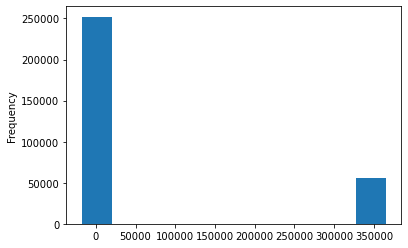

In [14]:
app_train['DAYS_EMPLOYED'].plot.hist()
plt.show()

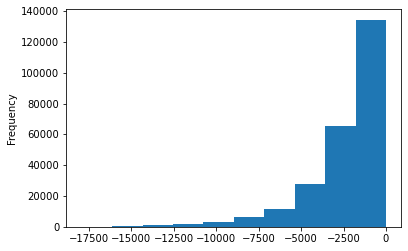

In [15]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243
app_train['DAYS_EMPLOYED'].replace({365243:np.nan},inplace=True)
app_train['DAYS_EMPLOYED'].plot.hist()
plt.show()

In [16]:
correlations = app_train.corr()['TARGET'].sort_values()
correlations.head()

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
Name: TARGET, dtype: float64

In [17]:
correlations.tail()

REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

In [18]:
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['TARGET'].corr(app_train['DAYS_BIRTH'])

-0.07823930830982712

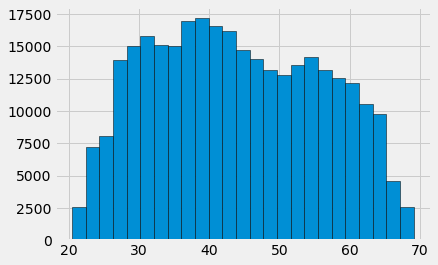

In [19]:
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH']/365,edgecolor='k',bins=25)
plt.show()

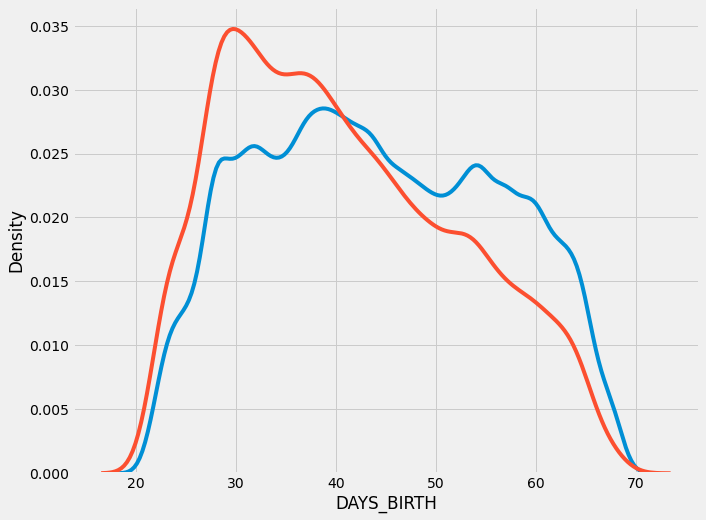

In [20]:
plt.figure(figsize=(10,8))
#KDEPLOT
sns.kdeplot(app_train.loc[app_train['TARGET']==0,'DAYS_BIRTH']/365,label='target==0')
sns.kdeplot(app_train.loc[app_train['TARGET']==1,'DAYS_BIRTH']/365,label='target==1')
plt.show()

In [21]:
age_data = app_train[['TARGET','DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH']/365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'],bins=np.linspace(20,70,num=11))
age_data.head()

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"


In [22]:
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


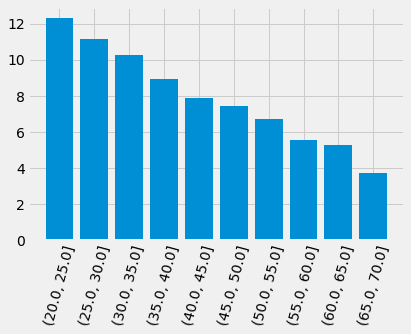

In [23]:
plt.bar(age_groups.index.astype(str),100*age_groups['TARGET'])
plt.xticks(rotation=75)
plt.show()

In [24]:
ext_data = app_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


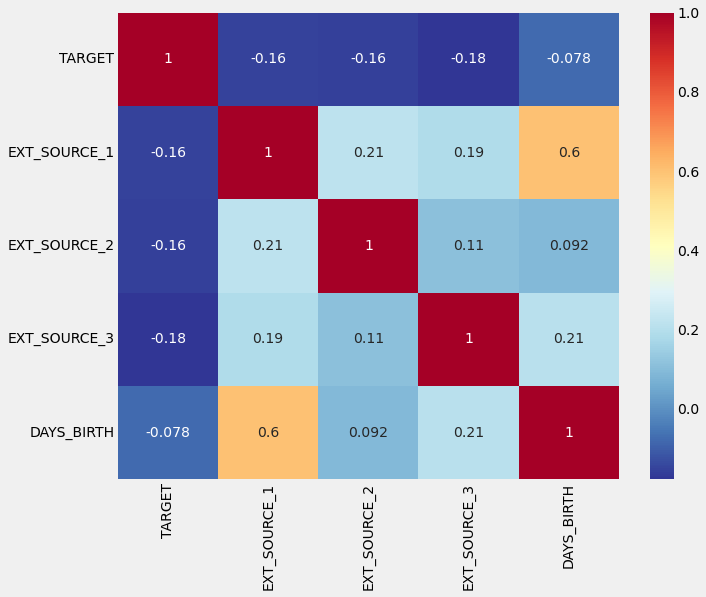

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(ext_data_corrs,cmap = plt.cm.RdYlBu_r,annot=True)
plt.show()

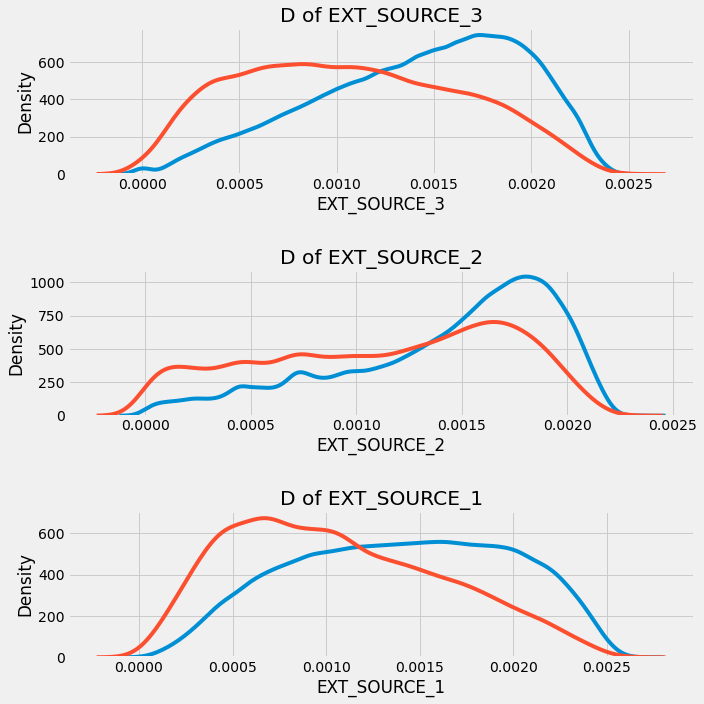

In [39]:
plt.figure(figsize=(10,10))
for i,source in enumerate(['EXT_SOURCE_3','EXT_SOURCE_2','EXT_SOURCE_1']):
    #
    plt.subplot(3,1,i+1)
    #kdeplot
    sns.kdeplot(app_train.loc[app_train['TARGET']==0,source]/365,label='target==0')
    sns.kdeplot(app_train.loc[app_train['TARGET']==1,source]/365,label='target==1')
    plt.title('D of %s' % source)
plt.tight_layout(h_pad=2.5)
plt.show()

In [44]:
target0 = app_train.loc[app_train['TARGET']==0].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,1,0,0,0,0,0,0,1,0,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,False
5,100008,0,0,0,1,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0,0,0,0,0,False


In [45]:
target1 = app_train.loc[app_train['TARGET']==1].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,1,0,1,0,False
26,100031,1,0,0,1,0,112500.0,979992.0,27076.5,702000.0,...,0,0,0,0,0,0,1,0,1,False
40,100047,1,0,0,1,0,202500.0,1193580.0,35028.0,855000.0,...,0,0,0,0,0,1,0,1,0,False
42,100049,1,0,0,0,0,135000.0,288873.0,16258.5,238500.0,...,0,0,0,0,0,0,0,0,0,False
81,100096,1,0,0,1,0,81000.0,252000.0,14593.5,252000.0,...,0,0,0,0,0,0,0,0,0,True


### Features engineering

In [27]:
poly_features = app_train[['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
from sklearn.preprocessing import PolynomialFeatures
# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

In [28]:
#Missing value padding
imputer = SimpleImputer(strategy='median')
poly_target = poly_features['TARGET']
poly_features.drop(columns=['TARGET'],inplace =True)
poly_features = imputer.fit_transform(poly_features)

In [29]:
poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)

In [30]:
poly_features.shape

(307511, 35)

In [31]:
poly_transformer.get_feature_names(input_features=['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH'])[:20]

['1',
 'TARGET',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'TARGET^2',
 'TARGET EXT_SOURCE_1',
 'TARGET EXT_SOURCE_2',
 'TARGET EXT_SOURCE_3',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_3^2',
 'TARGET^3',
 'TARGET^2 EXT_SOURCE_1',
 'TARGET^2 EXT_SOURCE_2',
 'TARGET^2 EXT_SOURCE_3',
 'TARGET EXT_SOURCE_1^2']

Combine the currently obtained partial features with the population

In [32]:
poly_features = pd.DataFrame(poly_features,columns=poly_transformer.get_feature_names(input_features=['TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']))
poly_features.head()

,1,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET^2,TARGET EXT_SOURCE_1,TARGET EXT_SOURCE_2,TARGET EXT_SOURCE_3,EXT_SOURCE_1^2,...,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,0.171798,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,0.275185,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,0.033616,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12


In [34]:
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features,on='SK_ID_CURR',how='left')
app_train_poly.head()

,SK_ID_CURR,TARGET_x,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,EXT_SOURCE_1^3,EXT_SOURCE_1^2 EXT_SOURCE_2,EXT_SOURCE_1^2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2^2,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0.018181,0.009637,654.152107,0.005108,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0.240927,0.207254,6491.237078,0.178286,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0.171798,0.225464,5885.942404,0.295894,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0.275185,0.226462,8040.528832,0.186365,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0.033616,0.055754,2076.117157,0.092471,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12


Create features based on the actual situation

In [35]:
app_train_domain = app_train.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

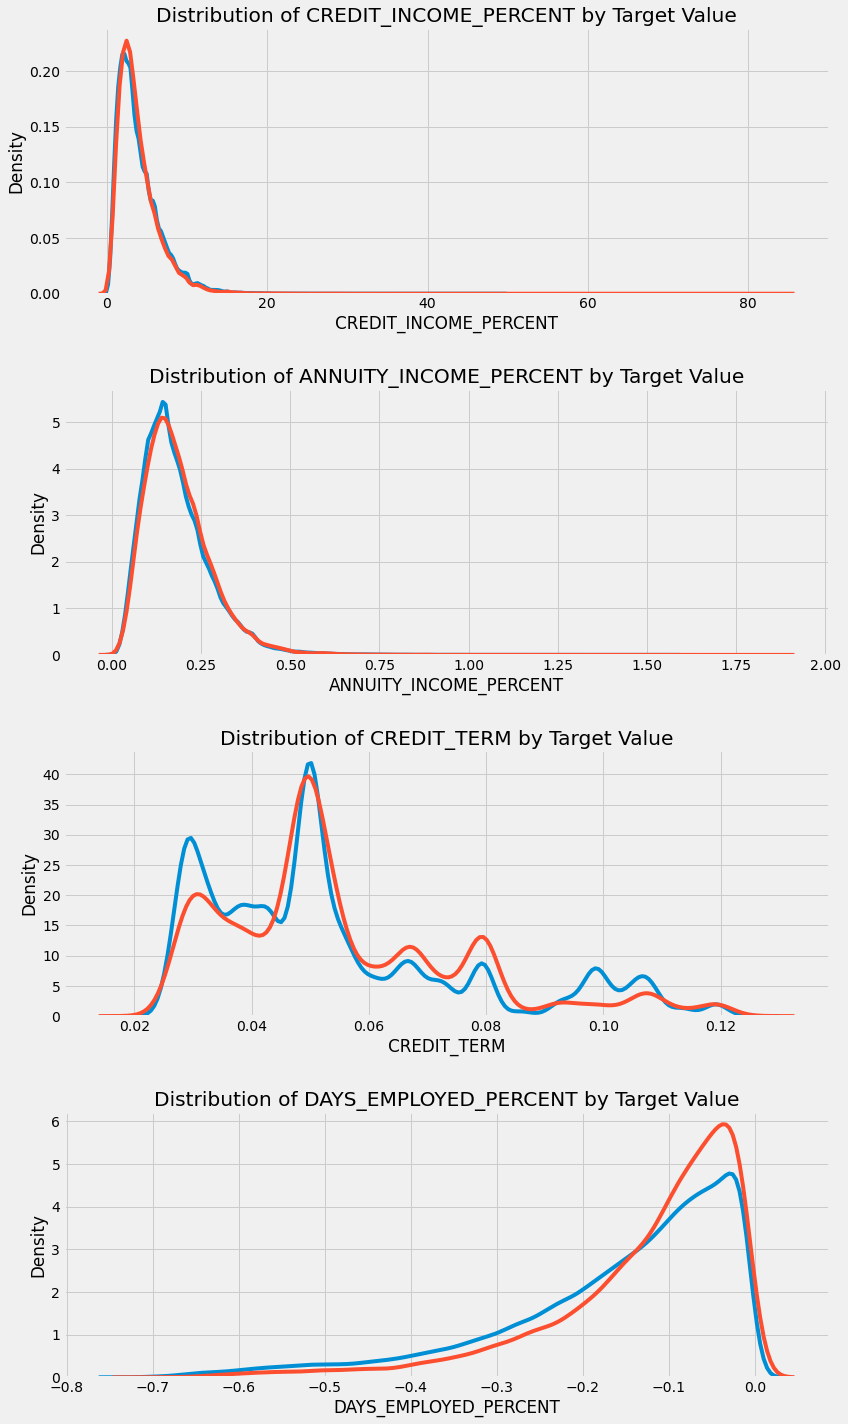

In [36]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
plt.show()

In [46]:
poly_features.head()

,1,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET^2,TARGET EXT_SOURCE_1,TARGET EXT_SOURCE_2,TARGET EXT_SOURCE_3,EXT_SOURCE_1^2,...,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3,SK_ID_CURR,cluster,principal_feature1,principal_feature2
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,100002,8,2.600096,-0.043521
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,100003,1,-0.392502,-0.420808
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,100004,3,-1.161533,0.453267
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,100006,6,-0.740900,-0.375146
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,100007,0,-0.139800,1.272415


In [71]:
poly_features.loc[app_train['TARGET'] == 0]

,1,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET^2,TARGET EXT_SOURCE_1,TARGET EXT_SOURCE_2,TARGET EXT_SOURCE_3,EXT_SOURCE_1^2,...,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3,SK_ID_CURR,cluster,principal_feature1,principal_feature2
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,100003,1,-0.392502,-0.420808
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,100004,3,-1.161533,0.453267
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,100006,6,-0.740900,-0.375146
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,100007,0,-0.139800,1.272415
5,1.0,0.505998,0.354225,0.621226,16941.0,0.256034,0.179237,0.314339,8572.110941,0.125475,...,3727.930293,1.016616e+08,0.239745,6537.907365,1.782904e+08,4.862024e+12,100008,5,-0.102014,1.043980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307505,1.0,0.505998,0.346391,0.742182,24384.0,0.256034,0.175273,0.375542,12338.253537,0.119987,...,6268.767660,2.059572e+08,0.408819,13431.525157,4.412859e+08,1.449823e+13,456249,0,-1.424551,1.914157
307506,1.0,0.145570,0.681632,0.535276,9327.0,0.021191,0.099226,0.077920,1357.735625,0.464623,...,3403.064320,5.929720e+07,0.153368,2672.378236,4.656525e+07,8.113830e+11,456251,7,0.428345,-1.306744
307507,1.0,0.505998,0.115992,0.535276,20775.0,0.256034,0.058692,0.270849,10512.107006,0.013454,...,1289.874083,5.006225e+07,0.153368,5952.466801,2.310256e+08,8.966503e+12,456252,0,0.206414,2.332709
307508,1.0,0.744026,0.535722,0.218859,14966.0,0.553575,0.398591,0.162837,11135.099105,0.286998,...,1754.727146,1.199916e+08,0.010483,716.860892,4.902031e+07,3.352102e+12,456253,2,1.042163,-0.755853


In [74]:
# data1 = poly_features.loc[poly_features['TARGET'] >= 0.5]
# data0 = poly_features.loc[poly_features['TARGET'] < 0.5]
# data0 = poly_features.loc[app_train['TARGET'] == 0]
# data1 = poly_features.loc[app_train['TARGET'] == 1]
# data11 = data1[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']]
# data00 = data0[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']]

data = poly_features[['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']]
X = data.values
n_cluster = range(1, 20)
 
#Standardization mean is 0 and the standard deviation is 1
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
 
#Reduce the feature dimension to 2
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# Standardization
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
poly_features['cluster'] = kmeans[9].predict(data)
poly_features.index = data.index
poly_features['principal_feature1'] = data[0]
poly_features['principal_feature2'] = data[1]
poly_features.head()

,1,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET^2,TARGET EXT_SOURCE_1,TARGET EXT_SOURCE_2,TARGET EXT_SOURCE_3,EXT_SOURCE_1^2,...,EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_3^2,EXT_SOURCE_2^3,EXT_SOURCE_2^2 EXT_SOURCE_3,EXT_SOURCE_2 EXT_SOURCE_3^2,EXT_SOURCE_3^3,SK_ID_CURR,cluster,principal_feature1,principal_feature2
0,1.0,0.083037,0.262949,0.139376,9461.0,0.006895,0.021834,0.011573,785.612748,0.069142,...,346.733022,2.353667e+07,0.002707,183.785678,1.247560e+07,8.468590e+11,100002,3,2.600096,-0.043521
1,1.0,0.311267,0.622246,0.535276,16765.0,0.096887,0.193685,0.166614,5218.396475,0.387190,...,5583.975307,1.748916e+08,0.153368,4803.518937,1.504475e+08,4.712058e+12,100003,7,-0.392502,-0.420808
2,1.0,0.505998,0.555912,0.729567,19046.0,0.256034,0.281290,0.369159,9637.236584,0.309038,...,7724.580288,2.016572e+08,0.388325,10137.567875,2.646504e+08,6.908939e+12,100004,9,-1.161533,0.453267
3,1.0,0.505998,0.650442,0.535276,19005.0,0.256034,0.329122,0.270849,9616.490669,0.423074,...,6616.894625,2.349331e+08,0.153368,5445.325225,1.933364e+08,6.864416e+12,100006,7,-0.740900,-0.375146
4,1.0,0.505998,0.322738,0.535276,19932.0,0.256034,0.163305,0.270849,10085.550751,0.104160,...,3443.335521,1.282190e+08,0.153368,5710.929881,2.126570e+08,7.918677e+12,100007,6,-0.139800,1.272415


In [78]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance._set_value(i, np.linalg.norm(Xa-Xb))
    return distance
 
#Set the outliers_fraction
outliers_fraction = 0.01
 
# Get the distance from each point to the center of the cluster
distance = getDistanceByPoint(data, kmeans[9])
 
#The number of outliers is calculated according to the outliers_fraction
number_of_outliers = int(outliers_fraction*len(distance))
 
#Set the threshold of outliers
threshold = distance.nlargest(number_of_outliers).min()
 
#Determine whether a point is an outlier based on the threshold

poly_features['anomaly1'] = (distance >= threshold).astype(int)
 
#Visualization
fig, ax = plt.subplots(figsize=(12,10))
colors = {0:'blue', 1:'red'}
ax.scatter(poly_features['principal_feature1'], poly_features['principal_feature2'], c=poly_features["anomaly1"].apply(lambda x: colors[x]),s=1)
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show();


KeyError: 0